In [17]:
# ============================================================
# 0 · Mount Google Drive
# ============================================================
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import numpy as np
from PIL import Image
import tensorflow as tf

def prepare_image(path: str, img_size: int = 160) -> np.ndarray:
    """
    Load an image from disk, keep its aspect-ratio, centre-pad to a square
    canvas of `img_size`×`img_size`, and return a float32 NumPy array
    scaled to [0,1].

    Parameters
    ----------
    path : str
        Path to a JPG / PNG / etc.
    img_size : int, default 160
        Target size expected by the model.

    Returns
    -------
    np.ndarray
        Array of shape (img_size, img_size, 3), dtype float32, values in [0,1].
    """
    # 1. read → RGB
    img = Image.open(path).convert("RGB")
    w, h = img.size

    # 2. resize with unchanged aspect ratio (shorter side = img_size)
    scale = img_size / max(w, h)
    nw, nh = int(round(w * scale)), int(round(h * scale))
    img = img.resize((nw, nh), resample=Image.BILINEAR)

    # 3. letter-box (black padding) to square canvas
    canvas = Image.new("RGB", (img_size, img_size), (0, 0, 0))
    canvas.paste(img, ((img_size - nw) // 2, (img_size - nh) // 2))

    # 4. to float32 [0,1]
    arr = np.asarray(canvas, dtype="float32") / 255.0
    return arr


#prepare_image('/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg')


Prediction: PNEUMONIA
Probability: 0.9661


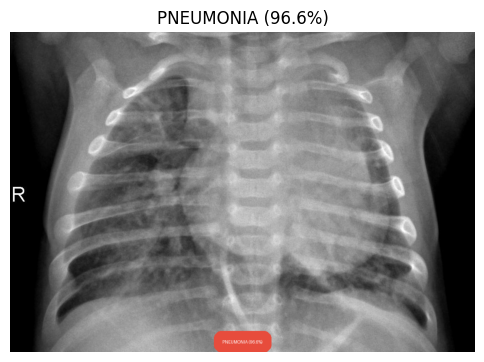

In [23]:
# Main prediction function
def predict_image(path):
    # Step 1: Prepare the image
    x = prepare_image(path, img_size=160)
    x = np.expand_dims(x, axis=0)  # add batch dimension

    # Step 2: Predict
    prob = model.predict(x, verbose=0)[0][0]  # sigmoid output

    # Step 3: Interpret prediction
    label = "PNEUMONIA" if prob >= 0.5 else "NORMAL"

    # Step 4: Draw the label on a copy of the image
    pil_img = Image.open(path).convert("RGB")
    badge = pil_img.copy()
    draw = ImageDraw.Draw(badge)
    W, H = badge.size

    font_size = W // 12
    try:
        font = ImageFont.truetype("arial.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    text = f"{label} ({prob*100:.1f}%)"

    # Correct way: use textbbox instead of textsize
    bbox = draw.textbbox((0, 0), text, font=font)
    text_w = bbox[2] - bbox[0]
    text_h = bbox[3] - bbox[1]

    pad, radius = 20, 18
    box = [(W - text_w)//2 - pad, H - text_h - 2*pad,
           (W + text_w)//2 + pad, H]

    color = (46, 204, 113) if label == "NORMAL" else (231, 76, 60)
    draw.rounded_rectangle(box, radius=radius, fill=color+(200,))
    draw.text(((W - text_w)//2, H - text_h - pad), text, fill="white", font=font)

    # Step 5: Return everything
    return {
        "probability": float(prob),
        "prediction": label,
        "image_with_label": badge
    }

import matplotlib.pyplot as plt

# After getting the result dictionary
path = '/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
result = predict_image(path)

# Display results
print(f"Prediction: {result['prediction']}")
print(f"Probability: {result['probability']:.4f}")

# Show the labeled image properly
plt.figure(figsize=(6,6))
plt.imshow(result['image_with_label'])
plt.axis('off')
plt.title(f"{result['prediction']} ({result['probability']*100:.1f}%)")
plt.show()
